# Alternate Model where Infection spread based on sufficient time passing using edge weights between neighbours rather than random chance

In [1]:
#Useful things
import networkx as nx
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import random

#Principle Component Analysis~
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Persistent Homology
from ripser import Rips
import gudhi as gd


In [2]:
class noisyRingMaker():
    
    def __init__(self,nodes,geo_edges,non_geo_edges):
        self.n = nodes
        self.g = nx.random_geometric_graph(self.n,0)
        self.geo_edges = geo_edges
        self.non_geo_edges = non_geo_edges
        self.edge_total = geo_edges + non_geo_edges
        self.pos = nx.circular_layout(self.g)
        self.distMat_exists = False
        
    #Make distance matrix for 2d Norm
    def twoD_distMat(self):
        self.distMat = np.zeros((self.n,self.n))

        for i in range(self.n):
            for j in range(i,self.n):
                self.distMat[i][j] = np.linalg.norm(self.pos[i]-self.pos[j])
                self.distMat[j][i] = self.distMat[i][j]
                
        self.distMat_exists = True
                
    #Adds edges between closest nodes
    def geometricEdgeAdder(self):
        nodes = []

        for i in range(self.distMat.shape[0]):
            nodes.append(np.argsort(self.distMat[i])[:self.geo_edges+1]) #Counts itself as one of its closest nodes so the +1 just compensates for that

        for n in self.g.nodes():
            for i in nodes[n]:
                if n != i: #Avoid self edges
                    self.g.add_edge(n,i)
                    
    #Version to run after geometric edges already added
    def nonGeometricEdgeAdder(self,debugging = True):
        degrees = np.array(self.g.degree)
        error = False
            
        for n in list(self.g.nodes()):
            
            if self.g.degree(n) == self.edge_total: #If the node already has enough connections
                continue #Move on to next node

            #Make a list of nodes that can be connected
            possible_nodes = list(self.g.nodes())
            max_degrees = list(degrees[degrees[:,1]==self.edge_total][:,0]) #Return a list of nodes with maximum degree
            exclude = list(self.g.neighbors(n)) + [n] + max_degrees
            exclude = list(dict.fromkeys(exclude)) #Remove duplicates
            
            for i in exclude: #Remove nodes that aren't eligible
                possible_nodes.remove(i)
                    
            if not possible_nodes: #If there's no possible connections (Shouldn't happen for sufficiently small geo k and enough n)
                if debugging == True:
                    print('No available nodes for node',n)
                error = True
                break

            for i in range(self.edge_total-self.g.degree(n)): #While the number of edges of that node is below the required total

                if len(possible_nodes) < self.edge_total-self.g.degree(n):
                    if debugging == True:
                        print('Not enough viable nodes for node',n)
                    error = True
                    break

                second_node = possible_nodes.pop(np.random.randint(len(possible_nodes))) #Pop out a random viable node (Popping means it won't be picked again when adding more edges)

                self.g.add_edge(n,second_node)
                
            if error == True:
                break
                
            degrees = np.array(self.g.degree)

            
    #Check the degree of each node is the same
    def checkDegrees(self):
        degrees = list(np.array(self.g.degree)[:,1])

        return all(elem == self.edge_total for elem in degrees)
    
    #Check the total number of edges is expected
    #def checkGraphEdges(self):
    #    return self.g.number_of_edges() == self.g.number_of_nodes() * (self.edge_total) /2    
            
    def makeNoisyRing(self,draw_Graph = True,debugging = False):
        if debugging == True:
            count = 1
        
        if (self.n % 2 == 1) or (self.geo_edges % 2 == 1):
            print('Please choose an even number of nodes and geometric edges')
            
        else:
            if debugging == True:
                print('Attempt #',count)
            self.twoD_distMat() #Only need to create a distance matrix once for the geometric edge adding
            self.geometricEdgeAdder()
            self.nonGeometricEdgeAdder(debugging)

            while (self.checkDegrees() == False): #If it doesn't meet the criteria, remove all edges and start over
                if debugging == True:
                    count += 1
                    print('Attempt #',count)
                self.g = nx.create_empty_copy(self.g)
                self.geometricEdgeAdder()
                self.nonGeometricEdgeAdder(debugging)

            if draw_Graph == True:
                nx.draw(self.g,self.pos)
                      
            return self.g
        

Attempt # 1
Not enough viable nodes for node 188
Attempt # 2


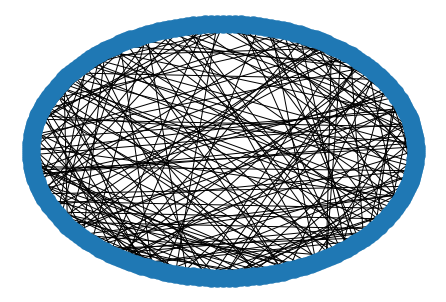

In [3]:
n = 200 #number of nodes

g = noisyRingMaker(n,12,2) #Initialise the node locations
g.twoD_distMat() #Make it's distance matrix of node embeddings
d = g.distMat #Save it
g = g.makeNoisyRing(debugging=True) #Make the graph itself with connections

In [4]:
class random_infection_model():
    
    #Initialise parameters
    def __init__(self,graph): 
        self.graph = nx.Graph.copy(graph)
        self.n = self.graph.number_of_nodes()
        self.distMap_exists = False
        self.distMap_P = None
        nx.set_node_attributes(self.graph,False,'infected')
        nx.set_node_attributes(self.graph,False,'to_be_infected')
        nx.set_node_attributes(self.graph,0,'infection_time')
        nx.set_node_attributes(self.graph,False,'source')
        self.edges_Weighted = False
        
    def resetModel(self):
        nx.set_node_attributes(self.graph,False,'infected')
        nx.set_node_attributes(self.graph,False,'to_be_infected')
        nx.set_node_attributes(self.graph,0,'infection_time')
        nx.set_node_attributes(self.graph,False,'source')
        
    #Assign random weights based on a geometric distribution using the probability of infection
    def randomEdgeWeights(self,trans_p):
        for i in self.graph.edges:
            self.graph.edges[i].update({'weight':np.random.geometric(trans_p)})
        
        self.edges_Weighted = True
        
    #Generate an infected cluster based on the choice of source node
    def clusterMaker(self,source,infect_neighbors = True):
        #Infect original node
        self.graph.nodes[source]['infected'] = True
        self.graph.nodes[source]['source'] = True

        #Infect neighbnouring nodes if option set to true.
        if infect_neighbors == True:
            for neighbor in self.graph.neighbors(source):
                self.graph.nodes[neighbor]['infected'] = True
                self.graph.nodes[neighbor]['source'] = True
                                
    #Check if sufficient number of neighbors are infected to pass on infection
    def randomInfector(self,trans_p,node,time):
        if (self.graph.nodes[node]['to_be_infected'] == False): #If the node isn't already scheduled for infection
            node_neighbours = list(self.graph.neighbors(node)) #Randomise node order since only one can cause infection
            np.random.shuffle(node_neighbours)
            for neighbour in node_neighbours: #Every infected neighbour has a chance to infect
                if self.graph.nodes[neighbour]['infected'] == True: #Check that the neighbour is infected
                    if time+1 >= self.graph.nodes[node]['infection_time'] + self.graph[node][neighbour]['weight']: 
                        #Check that the current time is greater than the time the neighbour became infected plus
                        #the wait time indicated by the edge weight. Plus one because the time is updated at the next step. 
                        #Note that since every neighbour is checked and steps are done incrementally, 
                        #this automatically uses the smallest edge weight between infected neighbours where sufficient time has passed.
                        self.graph.nodes[node]['to_be_infected'] = True
                        break #No need to check for every neighbor once it's infected
            
    #Update nodes that are set to be infected (done simultaneously at start of step)
    def infectedUpdater(self,time):
        for node in self.graph.nodes:
            if (self.graph.nodes[node]['to_be_infected'] == True) and (self.graph.nodes[node]['infected'] == False): #Infected condition is so it doesn't overlap times
                self.graph.nodes[node]['infected'] = True
                self.graph.nodes[node]['infection_time'] = time
            
    #Run a step of the infection
    def infectionStep(self,trans_p,time):
        for node in self.graph.nodes:
            self.infectedUpdater(time)

        for node in self.graph.nodes:
            self.randomInfector(trans_p,node,time)
            
    #Determine how many nodes are infected
    def infectionCounter(self):
        count = 0

        for _ in self.graph.nodes('infected'):
            if _[1] == True:
                count += 1

        return count
    
    #Replace infection time for nodes that will never be reached with 2*N
    def infinityNodeFixer(self):
        for node in self.graph.nodes:
            if (self.graph.nodes('source')[node] == False) and (self.graph.nodes('infection_time')[node] == 0): #Not a source node but never given an infection time
                self.graph.nodes[node]['infection_time'] = 2*self.n
                
    #For node colouring
    def graphColour(self):
        def convert_to_hex(rgba_color) :
            red = int(rgba_color[0]*255)
            green = int(rgba_color[1]*255)
            blue = int(rgba_color[2]*255)
            return '#%02x%02x%02x' % (red, green, blue)

        
        self.colors = [None] * self.n
        cmap = plt.get_cmap('hot')
        
        for node in self.graph.nodes:
            if self.graph.nodes('source')[node] == True:
                self.colors[node] = 'blue'
            elif self.graph.nodes('source')[node] == False and self.graph.nodes('infection_time')[node] == 0:
                self.colors[node] = 'grey'
            else:
                rgba = cmap(1-self.graph.nodes('infection_time')[node]/self.infection_time)
                self.colors[node] = convert_to_hex(rgba)
                
        #self.colors = ['red' if self.graph.nodes('infected')[node] == True else 'blue' for node in self.graph.nodes]
        #self.cmap = plt.get_cmap('hot')
        #self.colors = [1-self.graph.nodes('infection_time')[node]/self.infection_time for node in self.graph.nodes]
    
    #Infects the graph from start to end
    def graphInfector(self,case_zero,trans_p,infect_neighbors = False,resample_Edges = False,draw_Map = True):
        time = 0
        self.clusterMaker(case_zero,infect_neighbors)
        self.infection_timeline = [self.infectionCounter()]
        
        if self.edges_Weighted == False or resample_Edges == True: #We check to make sure this is only done once
            self.randomEdgeWeights(trans_p)
        
        for node in self.graph.nodes: #Need to prime nodes that will be infected at time 1
            self.randomInfector(trans_p,node,time)
                                                                                                                                            
        while self.infectionCounter() != self.n: #As long as the infection isn't total
            time += 1 
            self.infectionStep(trans_p,time) #Infect more
            #current_count = self.infectionCounter()
            self.infection_timeline.append(self.infectionCounter())
            
            if trans_p == 0: #Just for the fringe case where there's no chance of infection being transmitted
                time = 0
                break
            
            #In a rnadom infection the graph will always become infected provided that p > 0 and it's connected
            #Could do with a way of setting not connected nodes to infinity but this isn't necessary right now
            #if current_count == prior_infected: #If we haven't had any new infections this round
            #    time = time - 1 #Take time back a step because nothing changed
            #    break #Exit the infection loop
                
            #prior_infected = current_count #Update the current number of infectees
        
        if time == 0:
            self.infection_time = np.inf # Compensating for if the infection never manages to leave the initial cluster
        else:
            self.infection_time = time #Mark final infection time
            
        if draw_Map == True: #If we're drawing a complete map
            self.graphColour()
            pos = nx.circular_layout(self.graph)
            nx.draw(self.graph,pos=pos,node_color=self.colors)
            
        self.infinityNodeFixer() #Update all uninfected nodes to have infection time of 2*N
        
    #Create the matrix of time to node infection from each starting node
    def distMapMaker(self,trans_p,resample_Edges = False):
        self.distMap = np.zeros((self.n,self.n))
        
        if self.edges_Weighted == False or resample_Edges == True: #We check to make sure this is only done once
            self.randomEdgeWeights(trans_p)
            
        for i in range(self.n):
            for j in range(i,self.n):
                
                if i == j: #Diagonals are always distance 0 from themselves (If N is 0, 0 * inf returns NaN)
                    self.distMap[i][j] = 0.0
                else:
                    if nx.has_path(self.graph,i,j) == False:
                        self.distMap[i][j] = 2 * self.n
                    else:
                        self.distMap[i][j] = len(nx.shortest_path(self.graph,i,j,'weight'))-1 #subtract 1 as given as list of nodes in shortest path, number of edges is this number minus 1

                if self.distMap[i][j] == np.inf: #Fix nodes that will never be activated (when P is zero or they aren't connected)
                    self.distMap[i][j] = 2 * self.n

                self.distMap[j][i] = self.distMap[i][j]

                
        self.distMap_exists = True
        self.distMap_P = trans_p
        
        return self.distMap

In [5]:
#Make the timelines equivalent lengths
def timelineExtender(*timelines):
    length = 0
    
    #Cycle through to get longest timeline
    for item in timelines: 
        if len(item) > length:
            length = len(item)
    
    #Stick the last item on the end of the list until it matches the longest length item 
    for item in timelines:
        while len(item) < length: 
            item.append(item[-1])

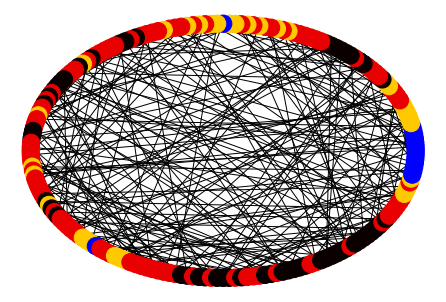

In [6]:
#Generate an RIM result
P_1 = 0.5
rand_1 = random_infection_model(g) #Assign model with input graph

rand_1.graphInfector(0,P_1,infect_neighbors=True,resample_Edges = True) #Simulate infection
    
infect_timeline_1 = rand_1.infection_timeline

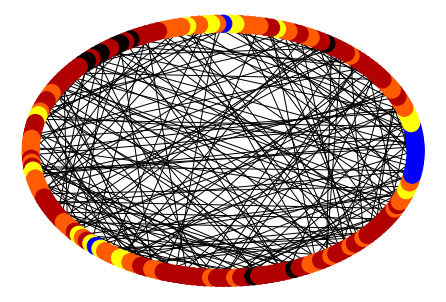

In [7]:
P_2 = 0.25
rand_2 = random_infection_model(g)

rand_2.graphInfector(0,P_2,infect_neighbors=True,resample_Edges=True)
    
infect_timeline_2 = rand_2.infection_timeline

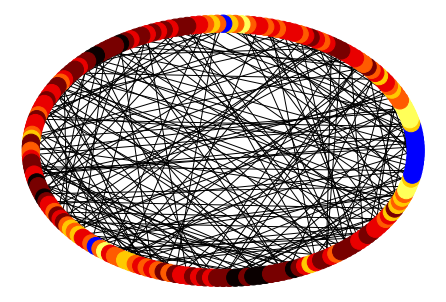

In [8]:
P_3 = 0.1
rand_3 = random_infection_model(g)

rand_3.graphInfector(0,P_3,infect_neighbors=True,resample_Edges=True)

infect_timeline_3 = rand_3.infection_timeline

In [9]:
timelineExtender(infect_timeline_1,infect_timeline_2,infect_timeline_3)

Text(0, 0.5, 'Number of Infections')

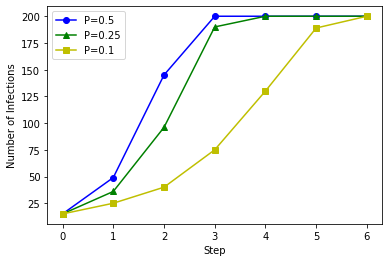

In [10]:
#Plot the cumulative rate of infections
plt.plot(rand_1.infection_timeline,'b-o',label='P={}'.format(P_1))
plt.plot(infect_timeline_2,'g-^',label='P={}'.format(P_2))
plt.plot(infect_timeline_3,'y-s',label='P={}'.format(P_3))
plt.legend()
plt.xlabel('Step')
plt.ylabel('Number of Infections')

## Persistent Homology

In [11]:
#Generate distance matrices
d_1 = rand_1.distMapMaker(P_1)
d_2 = rand_2.distMapMaker(P_2)
d_3 = rand_3.distMapMaker(P_3)

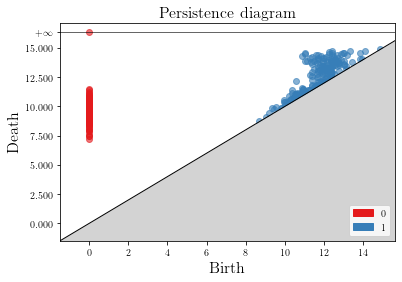

In [13]:
#Generate Persistence Diagrams
rips = gd.RipsComplex(d_1)
simplex = rips.create_simplex_tree(max_dimension=2)
barcodes_1 = simplex.persistence()
gd.plot_persistence_diagram(barcodes_1,legend=True)

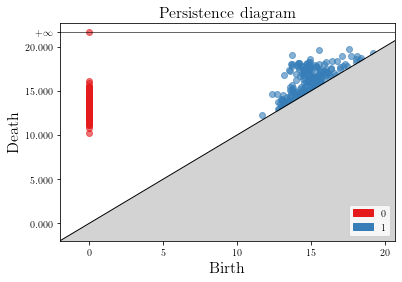

In [14]:
rips = gd.RipsComplex(d_2)
simplex = rips.create_simplex_tree(max_dimension=2)
barcodes_2 = simplex.persistence()
gd.plot_persistence_diagram(barcodes_2,legend=True)

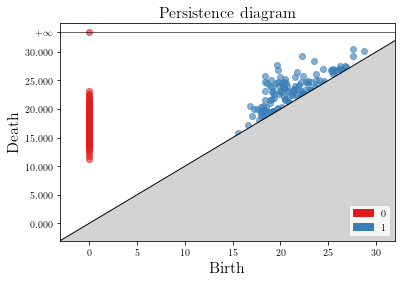

In [15]:
rips = gd.RipsComplex(d_3)
simplex = rips.create_simplex_tree(max_dimension=2)
barcodes_3 = simplex.persistence()
gd.plot_persistence_diagram(barcodes_3,legend=True)

## Principal Component Analysis

In [16]:
#Returns a dimensionally reduced distance matrix using Principle Component Analysis
def pcaTransformer(distance_matrix,n_components,svd_solver='full'):
    scaler = StandardScaler()
    
    scaler.fit(distance_matrix)
    dist_mat = scaler.transform(distance_matrix)
    
    pca = PCA(n_components,svd_solver=svd_solver)
    pca.fit(dist_mat)
    dist_mat = pca.transform(dist_mat)
    
    return dist_mat, pca

In [17]:
#Generates a 2D projection using a distance_matrix input with Principle Component Analysis
def twodProjector(distance_matrix,colors):
    pca = PCA(2)
    pca.fit(distance_matrix)
    points = pca.transform(distance_matrix)
    
    plt.scatter(points[:,0],points[:,1],c=colors)

In [23]:
#Determine the number of components with less than 5% unexplainable variance in the results
d_1t, pca_1 = pcaTransformer(d_1,0.95)
d_2t, pca_2 = pcaTransformer(d_2,0.95)
d_3t, pca_3 = pcaTransformer(d_3,0.95)

In [24]:
print('Model 1 Components:',pca_1.n_components_)
print('Model 2 Components:',pca_2.n_components_)
print('Model 3 Components:',pca_3.n_components_)

Model 1 Components: 67
Model 2 Components: 71
Model 3 Components: 64


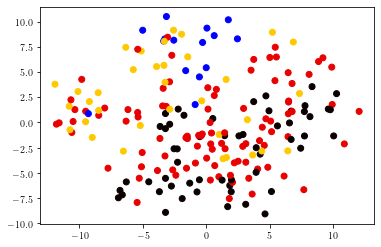

In [25]:
twodProjector(d_1t,rand_1.colors)

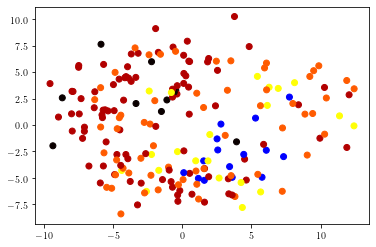

In [21]:
twodProjector(d_2t,rand_2.colors)

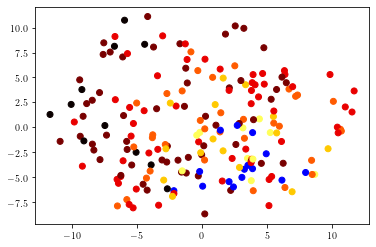

In [22]:
twodProjector(d_3t,rand_3.colors)